<a href="https://colab.research.google.com/github/pabloderen/BIMnferer/blob/master/Pipe_Analysis_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [179]:
import pandas as pd
import json
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np


# Download the Data

We download from de API in Flasgger (http://3.14.88.102:5000/apidocs/) the Pipe list item and it´s parameters


In [44]:
jsonfile = urllib.request.urlopen("http://3.14.88.102:5000/api/1/elements/pipes/?limit=6000").read().decode()
j=json.loads(jsonfile)

Then we make a Data Frame with the json file

# Create the DataFrame

In [45]:
df= pd.json_normalize(j)
df.head(3)

,projectId,Category,modelId,_id.$oid,properties_Dimensions_Length,properties_Dimensions_Size,properties_Mechanical_Material,properties_Mechanical_System Classification
0,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a82,NaN,NaN,NaN,NaN
1,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a83,NaN,NaN,NaN,NaN
2,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a84,0.398 ft,"2 1/2""",Copper,Sanitary


# Material Edition

we can see how many different materials we have, so then we will 
group by PVC, Copper and Steel

In [46]:
df["properties_Mechanical_Material"].unique()

array([nan, 'Copper', 'Steel, Carbon', '<By Category>',
       'Polyvinyl Chloride - Rigid', 'CP_PI - Copper - ASTM B88 H.D.',
       'CP_PI - Steel - ASTM A53-B', 'CP_PI - PVC', 'Cast Iron',
       'Black Steel', 'Carbon Steel', 'Ductile Iron',
       'Polyvinyl Chloride, Rigid', 'Carbon Steel - ASTM A53 B'],
      dtype=object)

To make such a grouping, we define a function that search in the "properties_Mechanical_Material" and change each row that has another different name for the same material

In [47]:
def search(data):
   
    if "A53" in data.upper():
        return "Carbon Steel - ASTM A53 B"
    if "CATEGORY" in data.upper():
        return "NaN"
    if "POLYVINYL" in data.upper():
        return "PVC"
    if "PVC" in data.upper():
        return "PVC"
    if "NAN" in data.upper():
        return "NaN"
    else:
        return data

For practical purpuses, we will make a copy of the DataFrame, 
then apply the function in each row of the "properties_Mechanical_Material" column.

In [48]:
df2=df
df2["properties_Mechanical_Material"]=df2["properties_Mechanical_Material"].apply(lambda x: search(str(x)))


here is the amount of each material kind

In [49]:

df2["properties_Mechanical_Material"].value_counts()


PVC                               1745
Carbon Steel - ASTM A53 B         1322
Carbon Steel                      1237
Copper                            1102
CP_PI - Copper - ASTM B88 H.D.     424
Steel, Carbon                      121
NaN                                 41
Black Steel                          4
Cast Iron                            2
Ductile Iron                         2
Name: properties_Mechanical_Material, dtype: int64

Here we can see a graphic of the different amount of each materials:

# Graphics

[Text(0, 0.5, 'Material')]

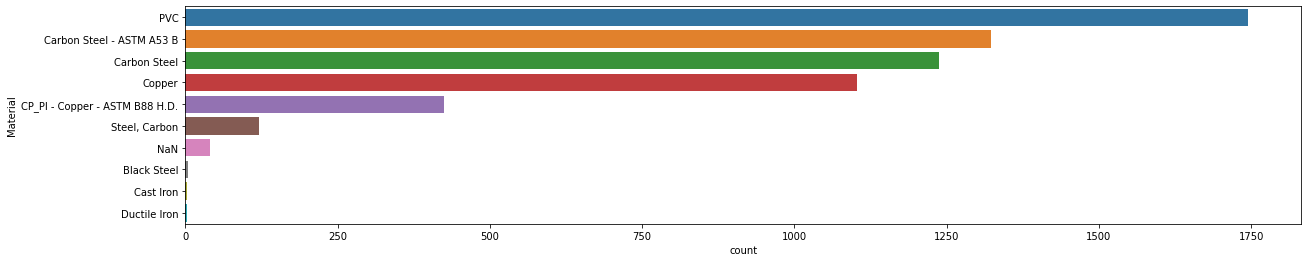

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,4))
ax=sns.countplot(y="properties_Mechanical_Material",data=df2,order=df2["properties_Mechanical_Material"].value_counts().index)
ax.set( ylabel="Material")

In [51]:
df2["properties_Mechanical_System Classification"].value_counts()

Sanitary               1499
Hydronic Supply        1496
Hydronic Return        1209
Domestic Cold Water     716
Vent                    417
Domestic Hot Water      321
Other                   187
Fire Protection Dry     116
Fire Protection Wet       2
Name: properties_Mechanical_System Classification, dtype: int64

Here we have an graphic of the system

[Text(0, 0.5, 'System Classification')]

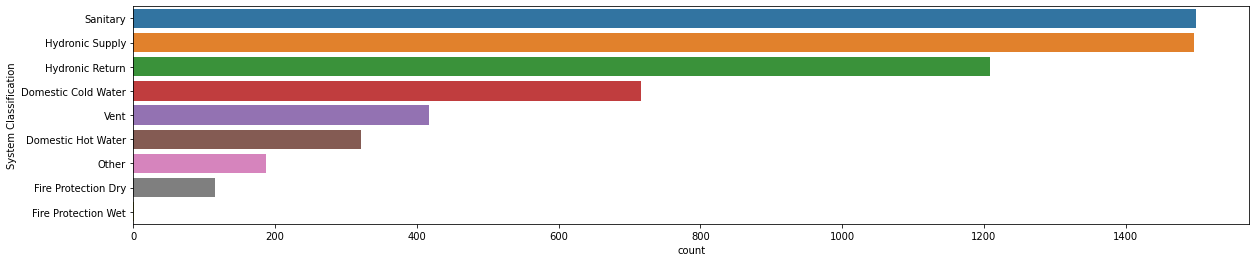

In [52]:
plt.figure(figsize=(20,4))
ax=sns.countplot(y="properties_Mechanical_System Classification",data=df2,order=df2["properties_Mechanical_System Classification"].value_counts().index)
ax.set( ylabel="System Classification")

# Length Edition

We drop the rows with properties_Dimensions_Length NaN values.

In [54]:
df3=df2.dropna(axis=0,subset=["properties_Dimensions_Length"])


Her we start to convert the properties_Dimensions_Length from string to float 
(we use x.replace(" ft","") and x.replace("  ft",""), notice the spaces in each case)



In [55]:
df3["properties_Dimensions_Length"]= df3["properties_Dimensions_Length"].apply(lambda x: x.replace(" ft",""))
df3["properties_Dimensions_Length"]= df3["properties_Dimensions_Length"].apply(lambda x: x.replace("  ft",""))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [56]:
df3["properties_Dimensions_Length"]= df3["properties_Dimensions_Length"].apply(lambda x: float(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Size Edition

we are analazing pipes, so we know that the dimensions Sizes are the diameter sizes. Then we can see that because a Size has the diameter simbol, creates another dimension. So we will take of the diameter simbol of all the column.

In [58]:
df3["properties_Dimensions_Size"].value_counts().head(5)

2"     643
4"ø    530
4"     522
6"ø    466
3"     436
Name: properties_Dimensions_Size, dtype: int64

In [59]:
df3["properties_Dimensions_Size"]= df3["properties_Dimensions_Size"].apply(lambda x: x.replace("ø",""))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Here we eliminate any leading and trailing whitespaces

In [60]:
df3["properties_Dimensions_Size"]= df3["properties_Dimensions_Size"].apply(lambda x: x.strip())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [61]:
df3["properties_Dimensions_Size"].value_counts()

4"        1070
2"         835
3/4"       727
6"         636
3"         592
1"         580
2 1/2"     316
1 1/4"     257
1/2"       241
1 1/2"     235
16"        146
14"         96
8"          84
12"         64
10"         60
5"          22
1 3/8"       2
Name: properties_Dimensions_Size, dtype: int64

[Text(0.5, 0, 'Dimensions Size')]

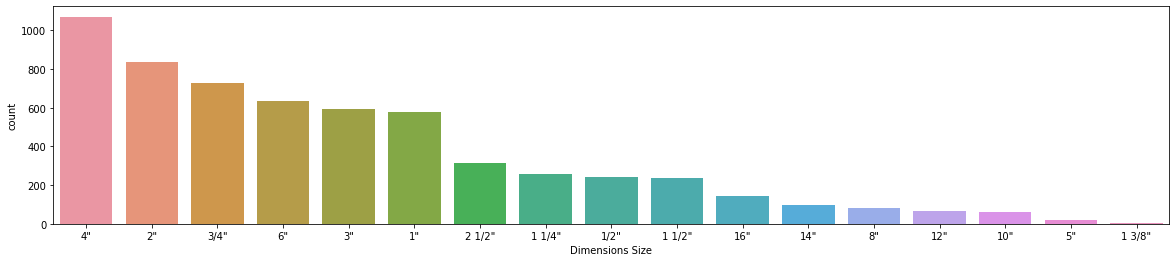

In [62]:
plt.figure(figsize=(20,4))
ax=sns.countplot(x="properties_Dimensions_Size",data=df3,order=df3["properties_Dimensions_Size"].value_counts().index)
ax.set( xlabel= "Dimensions Size")

# Enlist Materials

The ""properties_Mechanical_Material" are 10 different types. Our target of inference will be the differents kinds of materials

In [63]:
 lista = df3["properties_Mechanical_Material"].unique()
lista

array(['Copper', 'Steel, Carbon', 'NaN', 'PVC',
       'CP_PI - Copper - ASTM B88 H.D.', 'Carbon Steel - ASTM A53 B',
       'Cast Iron', 'Black Steel', 'Carbon Steel', 'Ductile Iron'],
      dtype=object)

Set a number designator to all properties_Mechanical_System Classification

In [64]:
dicc={}
i=0
for i in range(0,10):
  dicc[lista[i]]=i

we create a column with this designation

In [65]:
df3["Material_Number"]=df3["properties_Mechanical_Material"].apply(lambda x: dicc[x])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Dummies Data

Then we get the dummies properties_Dimensions_Size and properties Mechanical System Classification

In [66]:
df3["properties_Dimensions_Size"].nunique()

17

In [67]:
classification= pd.get_dummies(df3["properties_Mechanical_System Classification"])


In [68]:
Dimensions_Size= pd.get_dummies(df3["properties_Dimensions_Size"])


In [69]:
df4 = pd.concat([df3,classification,Dimensions_Size],axis=1)

We eliminate some columns that we will not use 

In [91]:
droplist=["Category","properties_Mechanical_System Classification","properties_Mechanical_Material","properties_Dimensions_Size", "projectId", "modelId","_id.$oid"]
df5=df4.drop(droplist, axis=1)

In [86]:
df5.head(3)

,Material_Number,Domestic Cold Water,Domestic Hot Water,Fire Protection Dry,Fire Protection Wet,Hydronic Return,Hydronic Supply,Other,Sanitary,Vent,"1 1/2""","1 1/4""","1 3/8""","1""","1/2""","10""","12""","14""","16""","2 1/2""","2""","3""","3/4""","4""","5""","6""","8"""
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


# Train Test Split

Here we define the size of our test size.
We can use all the data that we download in the first time, this is 6000 elemnts, to fit our model (I put just 0.1) and then we can use another extra data downloaded to prove our inference.

In [92]:
X = df5.drop('Material_Number',axis=1)
y = df5['Material_Number']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

# Model Fit

 Here we train our Random Forest

In [93]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Predictions

In [94]:
predictions = rfc.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       116
           1       1.00      1.00      1.00         6
           3       0.99      0.98      0.99       173
           4       0.77      0.94      0.85        47
           5       1.00      0.99      0.99       138
           8       0.95      0.97      0.96       117

    accuracy                           0.95       597
   macro avg       0.94      0.95      0.94       597
weighted avg       0.95      0.95      0.95       597



In [95]:
print(confusion_matrix(y_test,predictions))

[[ 98   0   2  13   0   3]
 [  0   6   0   0   0   0]
 [  3   0 170   0   0   0]
 [  2   0   0  44   0   1]
 [  0   0   0   0 136   2]
 [  4   0   0   0   0 113]]


In [84]:
dicc

{'Black Steel': 7,
 'CP_PI - Copper - ASTM B88 H.D.': 4,
 'Carbon Steel': 8,
 'Carbon Steel - ASTM A53 B': 5,
 'Cast Iron': 6,
 'Copper': 0,
 'Ductile Iron': 9,
 'NaN': 2,
 'PVC': 3,
 'Steel, Carbon': 1}

# Download the Data (second part)

The next step, is download 6500 elements of pipes type from de API in Flasgger (http://3.14.88.102:5000/apidocs/), so we can get the difference bettwen these 6500 and the first 6000. Then we make the same edition with these 500 elemnts, and get the predictions, just to prove our inference

In [96]:

jsonfile2= urllib.request.urlopen("http://3.14.88.102:5000/api/1/elements/pipes/?limit=6500").read().decode()
j2=json.loads(jsonfile2)

In [125]:
dataf= pd.json_normalize(j2)
dataf.head(3)

,projectId,Category,modelId,_id.$oid,properties_Dimensions_Length,properties_Dimensions_Size,properties_Mechanical_Material,properties_Mechanical_System Classification
0,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a82,NaN,NaN,NaN,NaN
1,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a83,NaN,NaN,NaN,NaN
2,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a84,0.398 ft,"2 1/2""",Copper,Sanitary


# Get Difference bettween 1° and 2° data

In [126]:
Testdata = dataf.iloc[6000:6500]
Testdata

,projectId,Category,modelId,_id.$oid,properties_Dimensions_Length,properties_Dimensions_Size,properties_Mechanical_Material,properties_Mechanical_System Classification
6000,b.4a3f3688-6014-48fc-9fe6-fe20d2b35b5a,Pipes,c2f0334e-f30b-062f-6718-11792657e163,5eee8d6fcb573f2fc2237864,18.709 ft,"1 1/2""ø",Carbon Steel,Hydronic Return
6001,b.4a3f3688-6014-48fc-9fe6-fe20d2b35b5a,Pipes,c2f0334e-f30b-062f-6718-11792657e163,5eee8d6fcb573f2fc2237865,18.709 ft,"1 1/2""ø",Carbon Steel,Hydronic Supply
6002,b.4a3f3688-6014-48fc-9fe6-fe20d2b35b5a,Pipes,c2f0334e-f30b-062f-6718-11792657e163,5eee8d6fcb573f2fc2237866,18.709 ft,"1 1/2""ø",Carbon Steel,Hydronic Supply
6003,b.4a3f3688-6014-48fc-9fe6-fe20d2b35b5a,Pipes,c2f0334e-f30b-062f-6718-11792657e163,5eee8d6fcb573f2fc2237867,18.501 ft,"3""ø",Carbon Steel,Hydronic Return
6004,b.4a3f3688-6014-48fc-9fe6-fe20d2b35b5a,Pipes,c2f0334e-f30b-062f-6718-11792657e163,5eee8d6fcb573f2fc2237868,18.501 ft,"3""ø",Carbon Steel,Hydronic Return
...,...,...,...,...,...,...,...,...
6495,b.4a3f3688-6014-48fc-9fe6-fe20d2b35b5a,Pipes,c2f0334e-f30b-062f-6718-11792657e163,5eee8d70cb573f2fc2237a53,4.218 ft,"3""ø",Carbon Steel,Hydronic Return
6496,b.4a3f3688-6014-48fc-9fe6-fe20d2b35b5a,Pipes,c2f0334e-f30b-062f-6718-11792657e163,5eee8d70cb573f2fc2237a54,4.218 ft,"3""ø",Carbon Steel,Hydronic Return
6497,b.4a3f3688-6014-48fc-9fe6-fe20d2b35b5a,Pipes,c2f0334e-f30b-062f-6718-11792657e163,5eee8d70cb573f2fc2237a55,1.078 ft,"3""ø",Carbon Steel,Hydronic Return
6498,b.4a3f3688-6014-48fc-9fe6-fe20d2b35b5a,Pipes,c2f0334e-f30b-062f-6718-11792657e163,5eee8d70cb573f2fc2237a56,1.078 ft,"3""ø",Carbon Steel,Hydronic Return


# Material Edition (second part)

In [127]:
Testdata["properties_Mechanical_Material"].unique()

array(['Carbon Steel'], dtype=object)

In [128]:
def search(data):
   
    if "A53" in data.upper():
        return "Carbon Steel - ASTM A53 B"
    if "CATEGORY" in data.upper():
        return "NaN"
    if "POLYVINYL" in data.upper():
        return "PVC"
    if "PVC" in data.upper():
        return "PVC"
    if "NAN" in data.upper():
        return "NaN"
    else:
        return data

In [129]:
Testdata2=Testdata
Testdata2["properties_Mechanical_Material"]=Testdata2["properties_Mechanical_Material"].apply(lambda x: search(str(x)))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [130]:
Testdata2["properties_Mechanical_Material"].value_counts()


Carbon Steel    500
Name: properties_Mechanical_Material, dtype: int64

# Length Edition (second Part)

In [131]:
Testdata3=Testdata2.dropna(axis=0,subset=["properties_Dimensions_Length"])

In [132]:
Testdata3["properties_Dimensions_Length"]= Testdata3["properties_Dimensions_Length"].apply(lambda x: x.replace(" ft",""))
Testdata3["properties_Dimensions_Length"]= Testdata3["properties_Dimensions_Length"].apply(lambda x: x.replace("  ft",""))

In [134]:
Testdata3["properties_Dimensions_Length"]= Testdata3["properties_Dimensions_Length"].apply(lambda x: float(x))

# Size Edition (second part)

In [135]:
Testdata3["properties_Dimensions_Size"].value_counts().head(5)

3"ø        112
6"ø         83
4"ø         82
1 1/2"ø     75
1 1/4"ø     52
Name: properties_Dimensions_Size, dtype: int64

In [136]:
Testdata3["properties_Dimensions_Size"]= Testdata3["properties_Dimensions_Size"].apply(lambda x: x.replace("ø",""))

In [138]:
Testdata3["properties_Dimensions_Size"]= Testdata3["properties_Dimensions_Size"].apply(lambda x: x.strip())

In [139]:
Testdata3["properties_Dimensions_Size"].value_counts()

3"        112
6"         83
4"         82
1 1/2"     75
1 1/4"     52
2 1/2"     24
30"        22
3/4"       18
1"         18
2"          8
8"          4
36"         2
Name: properties_Dimensions_Size, dtype: int64

In [140]:
df3["properties_Dimensions_Size"].value_counts()

4"        1070
2"         835
3/4"       727
6"         636
3"         592
1"         580
2 1/2"     316
1 1/4"     257
1/2"       241
1 1/2"     235
16"        146
14"         96
8"          84
12"         64
10"         60
5"          22
1 3/8"       2
Name: properties_Dimensions_Size, dtype: int64

we compare the two list of sizes, and can see that don´t have the 36" diameter pipe, so we are going to drop these two rows (these have just 2 elemnts)

# Enlist Materials (Second Part)

We will use the same numbers that we used in the first part

In [143]:
Testdata3["Material_Number"]=Testdata3["properties_Mechanical_Material"].apply(lambda x: dicc[x])


# Dummies Data (second part)

In [144]:
classification= pd.get_dummies(Testdata3["properties_Mechanical_System Classification"])

In [145]:
Dimensions_Size= pd.get_dummies(Testdata3["properties_Dimensions_Size"])

In [146]:
Dimensions_Size

,"1 1/2""","1 1/4""","1""","2 1/2""","2""","3""","3/4""","30""","36""","4""","6""","8"""
6000,1,0,0,0,0,0,0,0,0,0,0,0
6001,1,0,0,0,0,0,0,0,0,0,0,0
6002,1,0,0,0,0,0,0,0,0,0,0,0
6003,0,0,0,0,0,1,0,0,0,0,0,0
6004,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,0,0,0,0,0,1,0,0,0,0,0,0
6496,0,0,0,0,0,1,0,0,0,0,0,0
6497,0,0,0,0,0,1,0,0,0,0,0,0
6498,0,0,0,0,0,1,0,0,0,0,0,0


In [147]:
Testdata4 = pd.concat([Testdata3,classification,Dimensions_Size],axis=1)

In [149]:
droplist=["Category","properties_Mechanical_System Classification","properties_Mechanical_Material","properties_Dimensions_Size", "projectId", "modelId","_id.$oid"]
Testdata5=Testdata4.drop(droplist, axis=1)

In [150]:
Testdata5.head()

,properties_Dimensions_Length,Material_Number,Domestic Cold Water,Hydronic Return,Hydronic Supply,"1 1/2""","1 1/4""","1""","2 1/2""","2""","3""","3/4""","30""","36""","4""","6""","8"""
6000,18.709,8,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
6001,18.709,8,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
6002,18.709,8,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
6003,18.501,8,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
6004,18.501,8,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [161]:
firstpartcol=df5.columns
secondpartcol=Testdata5.columns
len(secondpartcol)

17

In [172]:
len(firstpartcol)

28

In [178]:
li_toel=[]
li_toapp=[]
i=0
for i in range(0,28):
  if firstpartcol[i] in secondpartcol:
    li_toel.append(firstpartcol[i])
  else:
    li_toapp.append(firstpartcol[i])
li_toapp

['Domestic Hot Water',
 'Fire Protection Dry',
 'Fire Protection Wet',
 'Other',
 'Sanitary',
 'Vent',
 '1 3/8"',
 '1/2"',
 '10"',
 '12"',
 '14"',
 '16"',
 '5"']

In [181]:
liapp=[]
lipop=[]

i=0
for i in range(0,17):
  if secondpartcol[i] in firstpartcol:
    liapp.append(secondpartcol[i])
  else:
    lipop.append(secondpartcol[i])
lipop

['30"', '36"']

In [171]:
Testdata5.drop(lipop,axis=1,inplace=True)
Testdata5

,properties_Dimensions_Length,Material_Number,Domestic Cold Water,Hydronic Return,Hydronic Supply,"1 1/2""","1 1/4""","1""","2 1/2""","2""","3""","3/4""","4""","6""","8"""
6000,18.709,8,0,1,0,1,0,0,0,0,0,0,0,0,0
6001,18.709,8,0,0,1,1,0,0,0,0,0,0,0,0,0
6002,18.709,8,0,0,1,1,0,0,0,0,0,0,0,0,0
6003,18.501,8,0,1,0,0,0,0,0,0,1,0,0,0,0
6004,18.501,8,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,4.218,8,0,1,0,0,0,0,0,0,1,0,0,0,0
6496,4.218,8,0,1,0,0,0,0,0,0,1,0,0,0,0
6497,1.078,8,0,1,0,0,0,0,0,0,1,0,0,0,0
6498,1.078,8,0,1,0,0,0,0,0,0,1,0,0,0,0


In [191]:
Testdata6=Testdata5
Testdata6[reshaped_array]=0

ValueError: ignored

In [189]:
li_toapp
# convert list to numpy array
np_array=np.asarray(li_toapp)
# reshape array into 4 rows x 2 columns, and transpose the result
reshaped_array = np_array.reshape(1,13)



In [190]:
reshaped_array

array([['Domestic Hot Water', 'Fire Protection Dry',
        'Fire Protection Wet', 'Other', 'Sanitary', 'Vent', '1 3/8"',
        '1/2"', '10"', '12"', '14"', '16"', '5"']], dtype='<U19')